In [55]:
import dlib
import cv2
from imutils import face_utils
from scipy.spatial import distance 
import math
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
import pygame

pygame.mixer.init()
pygame.mixer.music.load('D:/Minor/alarm.wav')

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [56]:
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[12], mouth[16])
    mar = (A ) / (C)
    return mar

def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

def mouth_over_eye(eye):
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    mouth_eye = mar/ear
    return mouth_eye

In [57]:
import joblib
LGmodel = joblib.load("D:/Minor/LogReg_model.pkl")

In [58]:
#features = pd.DataFrame(columns=['EAR','MAR','PUC','MOE','EAR_N','MAR_N','PUC_N','MOE_N'])

#global flag
flag = 0

In [59]:
features_in_df = pd.DataFrame(columns=['EAR','MAR','PUC','MOE','EAR_N','MAR_N','PUC_N','MOE_N'])

In [60]:
#def model(landmarks,features_in_df):
def model(landmarks):
    #print('FEATURES PRINT START..')
    #print(features)
    #print('FEATURES RECIEVED IN MODEL FUNC')
    global features_in_df
    global flag

    df = pd.DataFrame(columns = ['EAR', 'MAR', 'PUC','MOE','EAR_N','MAR_N','PUC_N','MOE_N'])

    eye = landmarks[36:68]
    
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    puc = circularity(eye)
    moe = mouth_over_eye(eye)
    
    if flag == 0:
        #print('IN FLAG=0')
        df = df.append({'EAR':ear,'MAR': mar,'PUC': puc,'MOE': moe,'EAR_N':ear,'MAR_N':mar,'PUC_N':puc,'MOE_N':moe},ignore_index=True)
        features_in_df = features_in_df.append(df)
        flag += 1

    elif flag == 1:
        #print('IN FLAG=1')
        df = df.append({'EAR':ear+0.01,'MAR': mar+0.01,'PUC': puc+0.01,'MOE': moe+0.01,'EAR_N':ear+0.01,'MAR_N':mar+0.01,'PUC_N':puc+0.01,'MOE_N':moe+0.01},ignore_index=True)
        features_in_df = features_in_df.append(df)
        flag += 1

    else:
        #print('IN FLAG>1')
        # std of single variable
        
        ear_n = (ear - features_in_df["EAR"].mean(axis=0,skipna=True))/ features_in_df["EAR"].std(axis=0,skipna=True)
        mar_n = (mar - features_in_df["MAR"].mean(axis=0,skipna=True))/ features_in_df["MAR"].std(axis=0,skipna=True)
        puc_n = (puc - features_in_df["PUC"].mean(axis=0,skipna=True))/ features_in_df["PUC"].std(axis=0,skipna=True)
        moe_n = (moe - features_in_df["MOE"].mean(axis=0,skipna=True))/ features_in_df["MOE"].std(axis=0,skipna=True) 
       
        
        df = df.append({'EAR':ear,'MAR': mar,'PUC': puc,'MOE': moe,'EAR_N':ear_n,'MAR_N':mar_n,'PUC_N':puc_n,'MOE_N':moe_n},ignore_index=True)
        features_in_df = features_in_df.append(df)
        
        flag += 1
    #print('\n')
    #print(features_in_df)
    #print('\n')
    if len(df.index) != 0:
        Result = LGmodel.predict(df.values)

        if Result == 0:
            Result_String = "Alert"
        else:
            Result_String = "Drowsy"

        #return Result_String, df.values, features_in_df
        return Result_String, df.values
    else:
        return None

In [61]:
MAX_CONSEC_FRAMES = 15
COUNTER = 0

In [62]:
#features
#features_in_df = pd.DataFrame(columns=['EAR','MAR','PUC','MOE','EAR_N','MAR_N','PUC_N','MOE_N'])

In [63]:
def live():
    cap = cv2.VideoCapture(0)
    data = []
    result = []
    global features_in_df
    
    MAX_CONSEC_FRAMES = 15
    COUNTER = 0

    while True:

        _,image = cap.read()
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)
        
        ##### DETECTOR()  returns an object that contains points where an image can be found
        
        for rect in rects:
            
            shape = predictor(gray, rect)
            # predictor() inputs image and location where face can be found and returns coordinates of 68-facial landmarks 
            
            shape = face_utils.shape_to_np(shape)
            
            #if model(shape.reshape(68,2), features_in_df) is not None:
            if model(shape.reshape(68,2)) is not None:   
                #Result_String, features_in_nparray, features_in_df = model(shape.reshape(68,2), features_in_df)
                Result_String, features_in_nparray = model(shape.reshape(68,2))
                #features_in_df = features_in_df.append(features_in_df_rec)
                #print(features_in_df)
                
                cv2.putText(image,Result_String, bottomLeftCornerOfText, font, fontScale, fontColor,lineType)
                data.append(features_in_nparray)
                result.append(Result_String)

                for (x, y) in shape:
                    cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

                if Result_String == "Drowsy":
                    COUNTER += 1
                    if COUNTER >= MAX_CONSEC_FRAMES:
                        pygame.mixer.music.play(-1) 
                else:
                    pygame.mixer.music.stop()
                    COUNTER = 0
            else:
                pass
        
        cv2.imshow("Output", image)

        k = cv2.waitKey(1) & 0xFF
        if k == ord("q"):
            break

    cv2.destroyAllWindows()
    cap.release()
    
    return data,result

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,400)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

In [64]:
#features_in_df

In [65]:
data, result = live()

Text(0.5, 0, 'Time (Frames Captured)')

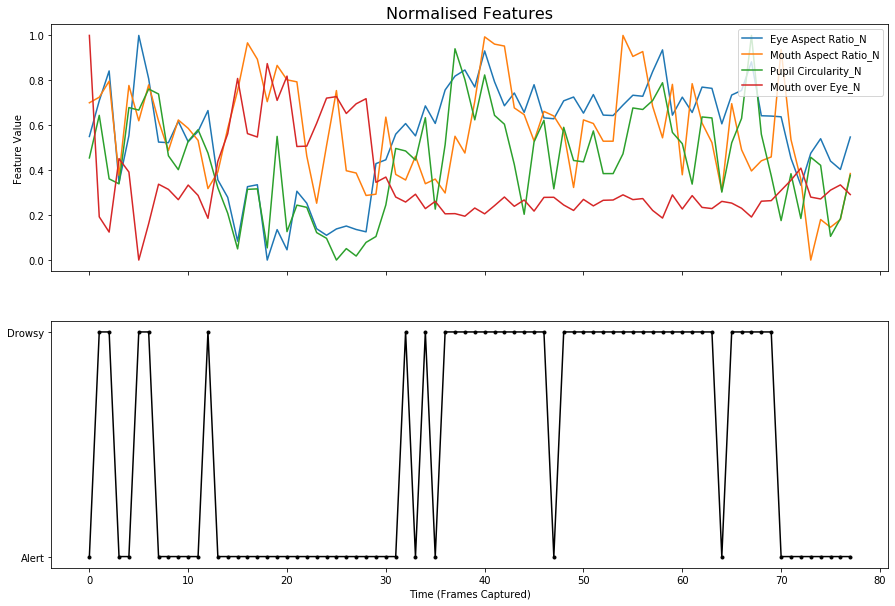

In [82]:
#Plot Results
data =np.vstack(data)
y = pd.DataFrame(data,columns=["EAR","MAR","PUC","MOE","EAR_N","MAR_N","PUC_N","MOE_N"])

x = y.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
y = pd.DataFrame(x_scaled,columns=["Eye Aspect Ratio","Mouth Aspect Ratio","Pupil Circularity","Mouth over Eye","Eye Aspect Ratio_N","Mouth Aspect Ratio_N","Pupil Circularity_N","Mouth over Eye_N"])
y["Result"] = result


fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=False,figsize=(15, 10))

ax1.set_title("Normalised Features",fontdict={'fontsize':16})
ax1.plot(y["Eye Aspect Ratio_N"], label="Eye Aspect Ratio_N")
ax1.plot(y["Mouth Aspect Ratio_N"], label="Mouth Aspect Ratio_N")
ax1.plot(y["Pupil Circularity_N"], label="Pupil Circularity_N")
ax1.plot(y["Mouth over Eye_N"], label="Mouth over Eye_N")
ax1.legend(loc="upper right")
ax1.set_ylabel('Feature Value')

ax2.plot(y["Result"],marker = '.', color = "Black")
ax2.set_xlabel('Time (Frames Captured)')

In [67]:
#del features

In [77]:
ax1.set_title?